<a href="https://colab.research.google.com/github/Vinjain301/IS517Project/blob/main/is517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/IS517Finalproject/Originaldata.csv'
movies_df = pd.read_csv(file_path)
movies_df.head()


,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Budget(INR),Revenue(INR),Unnamed: 14
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,5000000,85000,NaN
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,15000000,825000,NaN
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,75000000,56700000,NaN
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,210000000,4500000,NaN
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1000000,1075000,NaN


In [ ]:
print(movies_df.info())
print(movies_df.describe())
print(movies_df.isnull().sum())
print(f"Number of duplicate rows: {movies_df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698 entries, 0 to 1697
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie Name          1698 non-null   object 
 1   Release Period      1698 non-null   object 
 2   Whether Remake      1698 non-null   object 
 3   Whether Franchise   1698 non-null   object 
 4   Genre               1698 non-null   object 
 5   New Actor           1698 non-null   object 
 6   New Director        1698 non-null   object 
 7   New Music Director  1698 non-null   object 
 8   Lead Star           1698 non-null   object 
 9   Director            1698 non-null   object 
 10  Music Director      1698 non-null   object 
 11  Number of Screens   1698 non-null   int64  
 12  Budget(INR)         1698 non-null   int64  
 13  Revenue(INR)        1698 non-null   int64  
 14  Unnamed: 14         0 non-null      float64
dtypes: float64(1), int64(3), object(11)
memory usage: 199.1

In [ ]:
movies_df = movies_df.drop_duplicates()
print(f"Number of duplicate rows after removal: {movies_df.duplicated().sum()}")

Number of duplicate rows after removal: 0


Now we connect to the TMDB database and retrieve data to augment columns related to directors actors and  actress  like popularity scores,gender etc (parts of below code are taken from [TMDB api documentation](https://developer.themoviedb.org/docs/search-and-query-for-details)


In [ ]:
import requests
import csv

# TMDb API key
API_KEY = "fceca576b67a8b12435ca405a17f7842"

# Base URLs
BASE_URL = "https://api.themoviedb.org/3"
SEARCH_MOVIE_URL = f"{BASE_URL}/search/movie"
MOVIE_DETAILS_URL = f"{BASE_URL}/movie/{{movie_id}}"
MOVIE_CREDITS_URL = f"{BASE_URL}/movie/{{movie_id}}/credits"

# Extract movie names from the dataset
movie_names = movies_df['Movie Name'].tolist()

# List to keep track of not-found and filtered-out movies
not_found_movies = []
filtered_out_movies = []

# Function to get movie ID
def get_movie_id(movie_name):
    try:
        params = {
            "api_key": API_KEY,
            "query": movie_name,
        }
        response = requests.get(SEARCH_MOVIE_URL, params=params)
        response.raise_for_status()
        data = response.json()
        if data.get("results"):
            return data["results"][0]["id"]
        return None
    except Exception as e:
        print(f"Error fetching ID for movie '{movie_name}': {e}")
        return None

# Function to get all movie details
def get_movie_details(movie_id):
    try:
        url = MOVIE_DETAILS_URL.format(movie_id=movie_id)
        params = {"api_key": API_KEY}
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error fetching details for movie ID '{movie_id}': {e}")
        return {}

# Function to get movie credits (cast and crew)
def get_movie_credits(movie_id):
    try:
        url = MOVIE_CREDITS_URL.format(movie_id=movie_id)
        params = {"api_key": API_KEY}
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error fetching credits for movie ID '{movie_id}': {e}")
        return {"cast": [], "crew": []}

# Prepare data for CSV
csv_data = []
for movie in movie_names:
    try:
        movie_id = get_movie_id(movie)
        if not movie_id:
            not_found_movies.append(movie)  # Add to not-found list
            continue

        # Fetch movie details
        details = get_movie_details(movie_id)

        # Check for Hindi language and Indian origin
        if details.get('original_language') != 'hi' or 'IN' not in details.get('origin_country', []):
            filtered_out_movies.append(movie)  # Add to filtered-out list
            continue

        # Fetch movie credits
        credits = get_movie_credits(movie_id)

        # Add cast data
        for actor in credits.get("cast", []):
            csv_data.append({
                "Movie Name": movie,
                "Actor Name": actor.get("name"),
                "Character": actor.get("character"),
                "Actor ID": actor.get("id"),
                "Gender": actor.get("gender"),
                "Is Adult": actor.get("adult"),
                "Popularity": actor.get("popularity"),
                "Profile Path": actor.get("profile_path"),
                "Movie Details": details
            })

        # Add crew data
        for crew_member in credits.get("crew", []):
            csv_data.append({
                "Movie Name": movie,
                "Crew Member Name": crew_member.get("name"),
                "Job": crew_member.get("job"),
                "Department": crew_member.get("department"),
                "Crew Member ID": crew_member.get("id"),
                "Gender": crew_member.get("gender"),
                "Is Adult": crew_member.get("adult"),
                "Popularity": crew_member.get("popularity"),
                "Profile Path": crew_member.get("profile_path"),
                "Movie Details": details
            })
    except Exception as e:
        print(f"Error processing movie '{movie}': {e}")

# Save to CSV
csv_file = "bollywood_movies_full_details.csv"
fieldnames = [
    "Movie Name", "Actor Name", "Character", "Actor ID", "Gender", "Is Adult",
    "Crew Member Name", "Job", "Department", "Crew Member ID",
    "Popularity", "Profile Path", "Movie Details"
]

try:
    with open(csv_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(csv_data)
    print(f"Data saved to {csv_file}")
except Exception as e:
    print(f"Error saving to CSV: {e}")

# Save not-found movies to a file
not_found_file = "not_found_movies.csv"
try:
    with open(not_found_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Movie Name"])
        for movie in not_found_movies:
            writer.writerow([movie])
    print(f"Not-found movies saved to {not_found_file}")
except Exception as e:
    print(f"Error saving not-found movies: {e}")

# Save filtered-out movies to a file
filtered_out_file = "filtered_out_movies.csv"
try:
    with open(filtered_out_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Movie Name"])
        for movie in filtered_out_movies:
            writer.writerow([movie])
    print(f"Filtered-out movies saved to {filtered_out_file}")
except Exception as e:
    print(f"Error saving filtered-out movies: {e}")


Data saved to bollywood_movies_full_details.csv
Not-found movies saved to not_found_movies.csv
Filtered-out movies saved to filtered_out_movies.csv


In [ ]:
tmdb=pd.read_csv(csv_file)
tmdb.head()

As can be seen above the data has been retrieved in as json/dictionary and needs preprocessing before augmentation.


In [ ]:
import json
import ast
normalized_data = []

tmdb_copy = tmdb.copy()
tmdb_copy["Movie Details"] = tmdb_copy["Movie Details"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else {})

# Flatten the structure
normalized_data = []
for _, row in tmdb_copy.iterrows():
    row_dict = row.to_dict()
    movie_details = row_dict.pop("Movie Details", {})
    row_dict.update(movie_details)
    # Flatten genres, production_companies, and spoken_languages into strings
    row_dict["genres"] = ", ".join([genre["name"] for genre in movie_details.get("genres", [])])
    row_dict["production_companies"] = ", ".join([company["name"] for company in movie_details.get("production_companies", [])])
    row_dict["production_countries"] = ", ".join([country["name"] for country in movie_details.get("production_countries", [])])
    row_dict["spoken_languages"] = ", ".join([language["english_name"] for language in movie_details.get("spoken_languages", [])])
    normalized_data.append(row_dict)

flattened_tmdb = pd.DataFrame(normalized_data)  # Renamed to flattened_tmdb
output_path = "/content/drive/MyDrive/IS517Finalproject/flattened_movies_fixed.csv"
flattened_tmdb.to_csv(output_path, index=False)  # Use flattened_tmdb



In [ ]:
flattened_tmdb.head()

As can be seen above tmdb dataframe has been sufficiently flattened.Now we will combine it  with ou orignal dataset longitutadnally to augment information about actresses,reviews, sub genres,run time etc.

To join the tables longitutinally we will use the movie name(string) as we dont have a common id between the two tables.In order to do so we will use the rapid fuzz function which is just an otimized version of the fuzzy matching library.


In [ ]:
flattened_tmdb.rename(columns={'Movie Name': 'Movie','popularity':'Movie Popularity'}, inplace=True)
movies_df.rename(columns={'Lead Star': 'Actor'}, inplace=True)

In [ ]:
!pip install rapidfuzz


In [ ]:
from rapidfuzz import fuzz, process
import pandas as pd

# Fuzzy matching function to join data based on movie names
def fuzzy_merge(df1, df2, key1, key2, threshold=80, limit=1):
    matches = []
    for i, name in enumerate(df1[key1]):
        match = process.extractOne(name, df2[key2], scorer=fuzz.ratio)
        if match and match[1] >= threshold:
            best_match = df2[df2[key2] == match[0]].iloc[0]
            matches.append([df1.iloc[i], best_match])
    if matches:
        left = pd.DataFrame([x[0] for x in matches])
        right = pd.DataFrame([x[1] for x in matches])
        return pd.concat([left.reset_index(drop=True), right.reset_index(drop=True)], axis=1)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no matches found

# Fuzzy matching function for individual value matching (actor, director, music director)
def fuzzy_match(value, choices, threshold=85):
    results = process.extractOne(value, choices)
    if results is not None and len(results) >= 2:
        best_match, score = results[:2]
        return best_match if score >= threshold else None
    else:
        return None

# Function to add popularity scores for actor, director, and music director
def add_popularity_scores(row, flattened_tmdb):
    actor_name = row['Actor']
    director_name = row['Director']
    music_director_name = row['Music Director']

    # Fuzzy match Actor Popularity
    actor_match = fuzzy_match(actor_name, flattened_tmdb['Actor Name'].dropna().unique())
    row['Actor Popularity Score'] = flattened_tmdb[flattened_tmdb['Actor Name'] == actor_match]['Popularity'].values[0] if actor_match else None

    # Fuzzy match Director Popularity Score
    director_match = fuzzy_match(director_name, flattened_tmdb[flattened_tmdb['Job'] == 'Director']['Crew Member Name'].dropna().unique())
    row['Director Popularity Score'] = flattened_tmdb[flattened_tmdb['Crew Member Name'] == director_match]['Popularity'].values[0] if director_match else None

    # Fuzzy match Music Director Popularity Score
    music_director_match = fuzzy_match(music_director_name, flattened_tmdb['Crew Member Name'].dropna().unique())
    row['Music Director Popularity Score'] = flattened_tmdb[flattened_tmdb['Crew Member Name'] == music_director_match]['Popularity'].values[0] if music_director_match else None

    return row

# Perform fuzzy matching and merging to add actress-related variables
filtered_df = flattened_tmdb[(flattened_tmdb["Gender"] == 1) & (flattened_tmdb["Actor ID"].notna())]
filtered_df.rename(columns={'Actor Name':'Actress','Popularity': 'Actress Popularity Score'}, inplace=True)
sorted_df = filtered_df.sort_values(by='Actress Popularity Score', ascending=False)

# Step 1: Perform fuzzy merge
result = fuzzy_merge(movies_df, sorted_df, 'Movie Name', 'Movie', threshold=80)

# Step 2: Apply popularity scores after merging
popularity= result.apply(add_popularity_scores, axis=1, flattened_tmdb=flattened_tmdb)





In [ ]:
popularity.head()

In [ ]:
"""from rapidfuzz import fuzz, process

# Fuzzy matgching and joing function
def fuzzy_merge(df1, df2, key1, key2, threshold=80, limit=1):

  matches = []
  for i, name in enumerate(df1[key1]):
      match = process.extractOne(name, df2[key2], scorer=fuzz.ratio)
      if match and match[1] >= threshold:
          best_match = df2[df2[key2] == match[0]].iloc[0]
          matches.append([df1.iloc[i], best_match])
  if matches:
      left = pd.DataFrame([x[0] for x in matches])
      right = pd.DataFrame([x[1] for x in matches])
      return pd.concat([left.reset_index(drop=True), right.reset_index(drop=True)], axis=1)
  else:
      return pd.DataFrame()  # Return an empty DataFrame if no matches found

filtered_df = flattened_tmdb[(flattened_tmdb["Gender"] == 1) & (flattened_tmdb["Actor ID"].notna())]
sorted_df=filtered_df.sort_values(by='Popularity', ascending=False)
result = fuzzy_merge(movies_df, sorted_df, 'Movie Name', 'Movie Name', threshold=80)

# Save to csv
output_path = "/content/drive/MyDrive/IS517Finalproject/actress_fuzzy_matched_cleaned.csv"
result.to_csv(output_path)"""


In [ ]:
"""# function to perform fuzzy matching
def fuzzy_match(value, choices, threshold=85):

    # Extract the matched string, score, and index
    results = process.extractOne(value, choices)

    # Checks if resultsis empty or not
    if results is not None and len(results) >= 2:
        best_match, score = results[:2]  # Unpack the first two values

        return best_match if score >= threshold else None
    else:
        return None  # Handle cases where no match was found

# Prepare the data for fuzzy matching
actor_names = flattened_tmdb['Actor Name'].dropna().unique()
director_names = flattened_tmdb[flattened_tmdb['Job'] == 'Director']['Crew Member Name'].dropna().unique()
music_director_names = flattened_tmdb['Crew Member Name'].dropna().unique()

# Function to apply fuzzy matching for the relevant columns
def add_popularity_scores(row):
    actor_name = row['Lead Star']
    director_name = row['Director']
    music_director_name = row['Music Director']

    # Fuzzy match Actor Popularity
    actor_match = fuzzy_match(actor_name, actor_names)
    # Check if a fuzzy match was found before accessing Popularity
    row['Actor Popularity Score'] = flattened_tmdb[flattened_tmdb['Actor Name'] == actor_match]['Popularity'].values[0] if actor_match is not None and len(flattened_tmdb[flattened_tmdb['Actor Name'] == actor_match]) > 0 else None
    # Fuzzy match Director Popularity Score
    director_match = fuzzy_match(director_name, director_names)
    # Check if a fuzzy match was found before accessing Popularity
    row['Director Popularity Score'] = flattened_tmdb[flattened_tmdb['Crew Member Name'] == director_match]['Popularity'].values[0] if director_match is not None and len(flattened_tmdb[flattened_tmdb['Crew Member Name'] == director_match]) > 0 else None

    # Fuzzy match Music Director Popularity Score
    music_director_match = fuzzy_match(music_director_name, music_director_names)
    # Check if a fuzzy match was found before accessing Popularity
    row['Music Director Popularity Score'] = flattened_tmdb[flattened_tmdb['Crew Member Name'] == music_director_match]['Popularity'].values[0] if music_director_match is not None and len(flattened_tmdb[flattened_tmdb['Crew Member Name'] == music_director_match]) > 0 else None

    return row

actress_fuzzy_popularity = result.apply(add_popularity_scores, axis=1)"""

We have a scraped data about the major awards of the actors,actresses and Directors from Wikipedia:There three awards considered here: National awards,Filmfare awards and IFFA awards. We used the following Formula to create Points:  **1.5 X National awards, 1 X Filmare/IFFA, 1/Number
of Nominees for Nominations** (Based on the importance of these awards in india and bollywood)

Now  we will add this data to our popularity DF


In [ ]:
award_path = "/content/drive/MyDrive/IS517Finalproject/awards.csv"

award=pd.read_csv(award_path)
award

Now we augment the award points data to our main dataframe using fuzzy.

In [ ]:
# Prepare the data for fuzzy matching
actor_names = award[award['Role']=='Actor']['Name'].dropna().unique()
director_names = award[award['Role']=='Director']['Name'].dropna().unique()
actress_names = award[award['Role']=='Actress']['Name'].dropna().unique()

def add_award_scores(row):
    actor_name = row['Actor']
    director_name = row['Director']
    actress_name = row['Actress']

    # Fuzzy match Actor names and joinining award points
    actor_match = fuzzy_match(actor_name, actor_names)
    row['Actor Award Score'] = award[award['Name'] == actor_match]['Points'].values[0] if actor_match is not None and len(award[award['Name'] == actor_match]) > 0 else None

    #Fuzzy match Director names  and joinining award points
    director_match = fuzzy_match(director_name, director_names)
    row['Director Award Score'] = award[award['Name'] == actor_match]['Points'].values[0] if actor_match is not None and len(award[award['Name'] == director_match]) > 0 else None

    # Fuzzy match Actress names  and joinining award points
    actress_match = fuzzy_match(actress_name, actress_names)
    row['Actress Award Score'] = award[award['Name'] == actress_match]['Points'].values[0] if actress_match is not None and len(award[award['Name'] == actress_match]) > 0 else None
    return row

# Apply the function to each row
awards = popularity.apply(add_award_scores, axis=1)

In [ ]:
awards.head()

NameError: name 'awards' is not defined

Lets try and clean it up a bit since there is a significant increase in number of columns after the merge.

In [ ]:

import numpy as np
import pandas as pd


# flattening data
for column in awards.columns:
    if awards[column].apply(isinstance, args=(list,)).any():
        awards[column] = awards[column].apply(lambda x: tuple(x) if isinstance(x, list) else x)


# Check for missing values
missing_values = awards.isnull().sum()
print("Missing values count per column:\n", missing_values)

# Dropping unnecessary columns
columns_to_remove = [
    'Unnamed: 0', 'Movie', 'Character', 'Actor ID', 'Gender',
    'Crew Member Name', 'Job', 'Department', 'Crew Member ID', 'Profile Path',
    'backdrop_path', 'belongs_to_collection', 'budget', 'homepage', 'id',
    'original_language', 'original_title', 'overview', 'poster_path',
    'revenue', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'genres',
    'Unnamed: 14'
]
valid_columns_to_remove = list(set(columns_to_remove) & set(awards.columns))
awards = awards.drop(columns=valid_columns_to_remove)

# Encoding boolean columns
awards['Whether Remake'] = awards['Whether Remake'].map({"Yes": 1, "No": 0})
awards['Whether Franchise'] = awards['Whether Franchise'].map({"Yes": 1, "No": 0})
awards['New Actor'] = awards['New Actor'].map({"Yes": 1, "No": 0})
awards['New Director'] = awards['New Director'].map({"Yes": 1, "No": 0})
awards['New Music Director'] = awards['New Music Director'].map({"Yes": 1, "No": 0})
awards['Release Period'] = awards['Release Period'].map({"Holiday": 1, "Normal": 0})



if 'genres' in awards.columns:
    awards['genres'] = awards['genres'].apply(
        lambda x: ", ".join(eval(x)) if isinstance(x, str) and x.startswith('[') else x
    )
if 'production_countries' in awards.columns:
    awards['production_countries'] = awards['production_countries'].apply(
        lambda x: ", ".join(eval(x)) if isinstance(x, str) and x.startswith('[') else x
    )



# Convert newly added numerical columns to numeric type
awards['Budget(INR)'] = pd.to_numeric(awards['Budget(INR)'], errors='coerce')
awards['Revenue(INR)'] = pd.to_numeric(awards['Revenue(INR)'], errors='coerce')
awards['Actress Popularity Score'] = pd.to_numeric(awards['Actress Popularity Score'], errors='coerce')
awards['Actor Popularity Score'] = pd.to_numeric(awards['Actor Popularity Score'], errors='coerce')
awards['Director Popularity Score'] = pd.to_numeric(awards['Director Popularity Score'], errors='coerce')
awards['Popularity'] = pd.to_numeric(awards['Movie Popularity'], errors='coerce')
awards['Music Director Popularity Score'] = pd.to_numeric(awards['Music Director Popularity Score'], errors='coerce')
awards['Actor Award Score'] = pd.to_numeric(awards['Actor Award Score'],errors='coerce')

# Handle missing values in popularity columns
awards['Actress Popularity Score'].fillna(0, inplace=True)
awards['Actor Popularity Score'].fillna(0, inplace=True)
awards['Director Popularity Score'].fillna(0, inplace=True)
awards['Music Director Popularity Score'].fillna(0, inplace=True)
awards['Actor Award Score'].fillna(0, inplace=True)
awards['Director Award Score'].fillna(0, inplace=True)
awards['Actress Award Score'].fillna(0, inplace=True)
awards['Popularity'].fillna(0, inplace=True)

# Ensure date columns are in the correct format
awards['release_date'] = pd.to_datetime(awards['release_date'], errors='coerce')



# Display the first few rows of the resulting DataFrame
awards.head()


In [ ]:
missing_values = awards.isnull().sum()
print("Missing values count per column:\n", missing_values)


In [ ]:
awards['release_year'] = pd.to_datetime(awards['release_date'], errors='coerce').dt.year
awards['release_year'] = pd.to_numeric(awards['release_year'], errors='coerce')
awards['release_year'] = awards['release_year'].fillna(0).astype(int)
awards = awards.drop(columns=['release_date'])

awards.head()

In [ ]:

awards['imdb_id'] = awards['imdb_id'].fillna('Unknown')
missing_values_after_cleaning = awards.isnull().sum()
missing_values_after_cleaning


Now I will normalise and transform numeric variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Separate numeric features for normalization and standardization
popularity_features = ['Actress Popularity Score', 'Actor Popularity Score', 'Popularity','Director Popularity Score', 'Music Director Popularity Score']
award_features = ['Actor Award Score', 'Director Award Score', 'Actress Award Score']

scaler_popularity = MinMaxScaler()  # For normalization
scaler_award = StandardScaler()     # For standardization

# Normalize the popularity features
awards[popularity_features] = scaler_popularity.fit_transform(awards[popularity_features])

# Standardize the award features
awards[award_features] = scaler_award.fit_transform(awards[award_features])

awards.head()


**Important Transformations**

RBR: Revenue/Budget

RBR Category: (RBR<1: Loss, 1≤RBR<3 : Profit, RBR≥3:Blockbuster)

Vote Score: Vote_Avg x Vote_Count

Runtime Categories

In [ ]:

#  vote_score
awards['vote_score'] = awards['vote_count'] * awards['vote_average']

# Calculate RBR and categorize it
awards['RBR'] = awards['Revenue(INR)'] / awards['Budget(INR)']
awards['RBR Category'] = pd.cut(awards['RBR'],
                                bins=[-float('inf'), 1, 3, float('inf')],
                                labels=['Loss', 'Profit', 'Blockbuster'],
                                include_lowest=True)

# Categorize runtime
awards['Runtime Category'] = pd.cut(awards['runtime'],
                                    bins=[0, 90, 135, 160, float('inf')],
                                    labels=['Short', 'Medium', 'Long', 'Very Long'],
                                    include_lowest=True)

awards.head()


In [ ]:
output_path = "/content/drive/MyDrive/IS517Finalproject/cleaned_data.csv"
awards.to_csv(output_path)

Now to analyse the data we create a variariety of visualizations:

These include:

1.  Release Periods: Shows movie count for holiday vs. normal releases.
2.  Remakes: Shows movie count for remakes vs. originals.
3.   Movie Genres: Shows movie count per genre.
4.  Franchises: Shows movie count for franchise vs. standalone movies.
5.  New Actors: Shows movie count with new vs. established actors.
6.  New Directors: Shows movie count with new vs. established directors.
7.  New Music Directors: Shows movie count with new vs. established music directors.
7.  Movie Runtimes: Shows movie count by runtime category.
8.  RBR Categories: Shows movie count by financial performance (loss, profit, blockbuster).





In [ ]:
import matplotlib.pyplot as plt

categorical_columns = [
    'Genre',
    'Release Period',
    'Whether Remake',
    'Whether Franchise',
    'New Actor',
    'New Director',
    'New Music Director',
    'Runtime Category',
    'RBR Category'
]

colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink', 'lightseagreen']

for idx, column in enumerate(categorical_columns):
    plt.figure(figsize=(10, 6))
    ax = awards[column].value_counts().plot(kind='bar', title=f'Distribution of {column}', color=colors[idx % len(colors)])

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


We also create the following Tables:

1.**actor_movie_count**: Ranks actors by the number of movies they've appeared in, to identify the most prolific actors.

2.**director_movie_count**: Ranks directors by their movie count, to identify the most active directors.

3.**music_director_movie_count**: Ranks music directors by their movie count, to identify the most frequent music directors.

4.**actress_movie_count**: Ranks actresses by their movie count, to identify the most prolific actresses.


These tables are used to identify the most frequently appearing individuals in each role (actor, director, music director, and actress) within the movie dataset, which can be useful for understanding industry trends and prominence.

In [ ]:
from IPython.display import display

# Counting the number of movies for each actor, director, music director, and actress
actor_movie_count = awards['Actor'].value_counts().reset_index()
director_movie_count = awards['Director'].value_counts().reset_index()
music_director_movie_count = awards['Music Director'].value_counts().reset_index()
actress_movie_count = awards['Actress'].value_counts().reset_index()

actor_movie_count.columns = ['Actor', 'Number of Movies']
director_movie_count.columns = ['Director', 'Number of Movies']
music_director_movie_count.columns = ['Music Director', 'Number of Movies']
actress_movie_count.columns = ['Actress', 'Number of Movies']

print("Actor Movie Count:")
display(actor_movie_count.head())  # Display the first few rows using .head()

print("\nDirector Movie Count:")
display(director_movie_count.head())

print("\nMusic Director Movie Count:")
display(music_director_movie_count.head())

print("\nActress Movie Count:")
display(actress_movie_count.head())


Then we visualize how many actors, actresses, and directors are needed to cover a certain percentage of the movie dataset, showing their individual coverage and overall contribution.

In [ ]:


actors = awards['Actor'].dropna().unique()
directors = awards['Director'].dropna().unique()
actresses = awards['Actress'].dropna().unique()
total_movies = len(awards)

# Create a function to calculate percentage coverage
def calculate_percentage(people, column_name):
    coverage = {}
    for person in people:
        coverage[person] = len(awards[awards[column_name] == person]) / total_movies * 100
    return coverage

# Get percentage coverage for actors, actresses, and directors
actor_coverage = calculate_percentage(actors, 'Actor')
director_coverage = calculate_percentage(directors, 'Director')
actress_coverage = calculate_percentage(actresses, 'Actress')

def cumulative_distribution(coverage):
    sorted_coverage = np.sort(list(coverage.values()))
    cumulative_percentage = np.cumsum(sorted_coverage)
    return cumulative_percentage, range(1, len(sorted_coverage) + 1)

# Calculate cumulative distrbutions
actor_cumulative, actor_counts = cumulative_distribution(actor_coverage)
actress_cumulative, actress_counts = cumulative_distribution(actress_coverage)
director_cumulative, director_counts = cumulative_distribution(director_coverage)

# Plot the cumulative distribution
plt.figure(figsize=(10, 6))

plt.plot(actor_cumulative, actor_counts, label='Actors', marker='o')
plt.plot(actress_cumulative, actress_counts, label='Actresses', marker='x')
plt.plot(director_cumulative, director_counts, label='Directors', marker='s')
plt.xlabel('Percentage of Data Covered')
plt.ylabel('Number of Unique Individuals')
plt.title('Cumulative Coverage of Actors, Actresses, and Directors')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


The graph illustrates that directors (green line) have a significantly larger pool of unique individuals, with their numbers grows rapidly and surpasses the total for actors and actresses even when only 40% of the dataset is covered. In contrast, actors (blue line) and actresses (orange line) follow similar trends, with actresses slightly outpacing actors at higher coverage percentages.







Finally we make the correlation matrix to see the correlation between variable but befor we temporarily remove certain columns because of cardinality to simplify the correlation plot









In [ ]:
import seaborn as sns
existing_columns = awards.columns
print(existing_columns)
columns_to_remove = ['RBR Category', 'origin_country', 'Popularity','Movie','Runtime Category','Revenue(INR)','Genre' ,'adult','vote_average','vote_count', 'Unnamed: 0', 'Movie Name','release_year','production_countries','production_companies','imdb_id','Music Director','Director','Actor','Actress','']
valid_columns_to_remove = list(set(columns_to_remove) & set(existing_columns))
X = awards.drop(columns=valid_columns_to_remove)
X = pd.get_dummies(X, drop_first=True)


In [ ]:
X

In [ ]:
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

**Strong Positive Correlations:**


*Budget(INR) and Number of Screens (+0.88):* Higher budgets are strongly
associated with movies being released on more screens.

*Budget(INR) and Actor Popularity Score(+0.55):* Higher budgets are strongly
associated with movies having actors with higher popularity.

*Actor Popularity Score and Movie Popularity (+0.42):* A strong association suggests that movies with popular actors tend to be more popular.

*Runtime and Movie Popularity (+0.31):* Longer movies appear to have a slight association with higher popularity.

*RBR and Budget(INR) (+0.37):* Revenue-Budget Ratio (RBR) is moderately positively correlated with the budget.

*RBR and Vote Score  (+0.44):* Revenue-Budget Ratio (RBR) is moderately positively correlated with the critic vote score.

*Vote Score and Movie Popularity (+0.57):* Critic vote scores are strongly related with movie popularity.




**Strong Negative Correlations:**

*Actor Popularity Score and New Actor (-0.21):* New actors have low popularity scores.

*Actor Popularity Score and Whether Remake (-0.21):* Movies that are remakes seem to have lower associations with actor popularity.

*New Music Director and Director Award Score (-0.26)*: New music directors tend to correlate negatively with director award scores.


We dont eliminate any columns for now as I n want to see how they


In [ ]:
awards.columns.tolist()


In [ ]:
#Some more extra colums to get rid of
awards=awards.drop(columns=[ 'origin_country', 'Popularity','adult','vote_average','vote_count', 'production_countries','production_companies','imdb_id'])


In [ ]:
awards.columns.tolist()


Now we create a Bankablity score table which contains the relevant points for all actors,actresses and directors throughout the years (2004-2017).This would help us in calculating the yearwise bankablity score for all three members attached to a movie eventually.It would look like this:
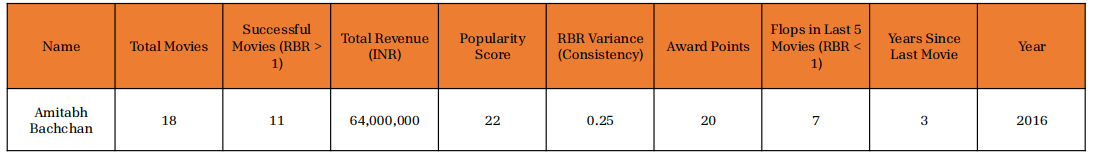

In [ ]:
from typing_extensions import final
# Filtering the relevant columns from the dataset
required_columns = [
    'Movie Name', 'Release Period', 'release_year', 'Actor', 'Actress', 'Director', 'RBR', 'Revenue(INR)',
    'Actor Popularity Score', 'Director Popularity Score', 'Music Director Popularity Score','Budget(INR)',
    'Actress Popularity Score', 'Actor Award Score', 'Director Award Score', 'Actress Award Score'
]
data_filtered = awards[required_columns]

# Let's now start processing for each year (2004-2017)
years = list(range(2004, 2018))
processed_data = []
for year in years:
    year_data = data_filtered[(data_filtered['release_year'] <= year) & (data_filtered['release_year'] >= 2004)]
    Target = ['Actor', 'Actress', 'Director']

    for person in Target:
        if person == 'Actor':
            grouped_data = year_data.groupby('Actor').agg(
                total_movies=('Movie Name', 'count'),
                successful_movies=('RBR', lambda x: (x > 1).sum()),
                total_revenue=('RBR', 'sum'),
                avg_popularity_score=('Actor Popularity Score', 'mean'),
                award_points=('Actor Award Score', 'mean'),
                consistency=('RBR', 'var'),
                flops_last_5_movies=('RBR', lambda x: (x.tail(5) < 1).sum()),
                years_since_last_movie=('release_year', lambda x: year - x.max())
            )
            grouped_data['Role'] = 'Actor'
            grouped_data['Name'] = grouped_data.index

        elif person == 'Actress':
            grouped_data = year_data.groupby('Actress').agg(
                total_movies=('Movie Name', 'count'),
                successful_movies=('RBR', lambda x: (x > 1).sum()),
                total_revenue=('RBR', 'sum'),
                avg_popularity_score=('Actress Popularity Score', 'mean'),
                award_points=('Actress Award Score', 'mean'),
                consistency=('RBR', 'var'),
                flops_last_5_movies=('RBR', lambda x: (x.tail(5) < 1).sum()),
                years_since_last_movie=('release_year', lambda x: year - x.max())
            )
            grouped_data['Role'] = 'Actress'
            grouped_data['Name'] = grouped_data.index

        else:
            grouped_data = year_data.groupby('Director').agg(
                total_movies=('Movie Name', 'count'),
                successful_movies=('RBR', lambda x: (x > 1).sum()),
                total_revenue=('RBR', 'sum'),
                avg_popularity_score=('Director Popularity Score', 'mean'),
                award_points=('Director Award Score', 'mean'),
                consistency=('RBR', 'var'),
                flops_last_5_movies=('RBR', lambda x: (x.tail(5) < 1).sum()),
                years_since_last_movie=('release_year', lambda x: year - x.max())
            )
            grouped_data['Role'] = 'Director'
            grouped_data['Name'] = grouped_data.index

        # Reset index after grouping to avoid issues with indexes
        grouped_data.reset_index(inplace=True)
        grouped_data['release_year'] = year
        processed_data.append(grouped_data)

# Combine all processed data
Bankability_data = pd.concat(processed_data, ignore_index=True)
Bankability_data=Bankability_data.drop(columns=['Actor','Director','Actress'])

# Display the final processed data
Bankability_data


In [ ]:
missing_values = Bankability_data.isnull().sum()

missing_values


In [ ]:
# Fill missing values in the 'consistency' column with 0
Bankability_data['consistency'] = Bankability_data['consistency'].fillna(0)

In [ ]:
missing_values = Bankability_data.isnull().sum()

missing_values

Now we calculate the bankablity score based on the following formula:

**Bankability Score= (α × Success Ratio)+(β×Popularity Score)+(γ × Consistency)+(δ ×
Awards Score)−(λ × Penalty Factor)**


Where,

 α,β,γ,δ,λ are weights attached to different factors

 Based on my domain knowledge I intuitively created these weights as:

 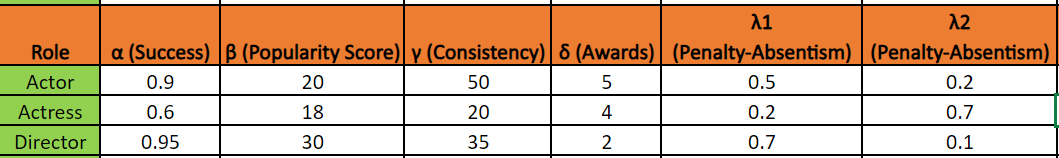


In [ ]:
# Assign the weights for each role
weights = {
    'Actor': {'α': 0.9, 'β': 20, 'γ': 50, 'δ': 5, 'λ1': 0.5,'λ2': 0.2},
    'Actress': {'α': 0.6, 'β': 18, 'γ': 20, 'δ': 4, 'λ1': 0.2,'λ2':0.7},
    'Director': {'α': 0.95, 'β': 30, 'γ': 35, 'δ': 2, 'λ1': 0.7,'λ2':0.1}
}

# Calculate Success Ratio and Penalty Factor
Bankability_data['Success Ratio'] = Bankability_data['successful_movies'] / Bankability_data['total_movies']
Bankability_data['Penalty Factor'] = Bankability_data.apply(lambda row: weights[row['Role']]['λ1'] * row['flops_last_5_movies'] + weights[row['Role']]['λ2'] * row['years_since_last_movie'], axis=1)
Bankability_data['Popularity Score'] = Bankability_data['avg_popularity_score']  # Use the relevant popularity score here
Bankability_data['Consistency'] = Bankability_data['consistency']  # RBR Variance
Bankability_data['Awards Score'] = Bankability_data['award_points']  # Average of award scores

# Function to apply weights based on role
def calculate_bankability(row):
    role = row['Role']
    weights_role = weights.get(role, {})
    bankability_score = (
        weights_role['α'] * row['Success Ratio'] +
        weights_role['β'] * row['Popularity Score'] +
        weights_role['γ'] * row['Consistency'] +
        weights_role['δ'] * row['Awards Score'] -row['Penalty Factor']    )

    return bankability_score

# Apply the function to calculate the Bankability Score for each individual
Bankability_data['Bankability Score'] = Bankability_data.apply(calculate_bankability, axis=1)
Bankability_data.head()


Now we standardise the Bankablity scores to bring them toa comman scale.

In [ ]:
# Find the minimum and maximum Bankability Scores
min_score = Bankability_data['Bankability Score'].min()
max_score = Bankability_data['Bankability Score'].max()

# Standardize the Bankability Score to a 0-100 scale
Bankability_data['Standardized Bankability Score'] = (
    (Bankability_data['Bankability Score'] - min_score) / (max_score - min_score)
) * 100

# Display the DataFrame with the standardized score
Bankability_data.head()

Merging the standardised bankablity to main dataset as actor,actress and director bankablity scores

In [ ]:
actors_data = Bankability_data[Bankability_data['Role'] == 'Actor']
actresses_data = Bankability_data[Bankability_data['Role'] == 'Actress']
directors_data = Bankability_data[Bankability_data['Role'] == 'Director']

# Rename the standardized bankability by role
actors_data = actors_data.rename(columns={'Standardized Bankability Score': 'Actor Bankability'})
actresses_data = actresses_data.rename(columns={'Standardized Bankability Score': 'Actress Bankability'})
directors_data = directors_data.rename(columns={'Standardized Bankability Score': 'Director Bankability'})
final_dataset = awards.copy()

final_dataset = final_dataset.merge(
    actors_data[['Name', 'release_year', 'Actor Bankability']],
    left_on=['Actor', 'release_year'],
    right_on=['Name', 'release_year'],
    how='left'
).drop(columns=['Name'])

final_dataset = final_dataset.merge(
    actresses_data[['Name', 'release_year', 'Actress Bankability']],
    left_on=['Actress', 'release_year'],
    right_on=['Name', 'release_year'],
    how='left'
).drop(columns=['Name'])

final_dataset = final_dataset.merge(
    directors_data[['Name', 'release_year', 'Director Bankability']],
    left_on=['Director', 'release_year'],
    right_on=['Name', 'release_year'],
    how='left'
).drop(columns=['Name'])


final_dataset.columns.tolist()


Now we start with the classification Task.As you already know the classification is going to basis the RBR category and we are trying a variety of Methods:


*   Logistic Regression
*   Logistic Regression (with lasso)
*   Random Forest
*   Enhanced Rf models(GridCV,Gradient Boost,XG Boost)
*   SVM
*   Ensemble(Voting Based)


Before we get going lets do some last steps for the classification













In [ ]:
# Drop high cardinality, related and correlated columns
columns_to_drop = ['Revenue(INR)', 'Runtime Category','Budget(INR)' ,'RBR', 'Movie Name', 'Actor', 'Actress', 'Director' ,'Music Director']
data_cleaned = final_dataset.drop(columns=columns_to_drop)

# Check for high cardinality categorical variables
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
cardinality_info = {col: data_cleaned[col].nunique() for col in categorical_columns}
high_cardinality_columns = {col: cardinality_info[col] for col in cardinality_info if cardinality_info[col] > 50}

# Check correlation between numeric variables
numerical_columns = data_cleaned.select_dtypes(include=['number']).columns
correlation_matrix = data_cleaned[numerical_columns].corr()

# Show the cardinality info and correlation matrix
high_cardinality_columns, correlation_matrix.head()


In [ ]:
# Remove highly correlated features (correlation > 0.9) while keeping "Actor Bankability", "Actress Bankability", and "Director Bankability"
corr_threshold = 0.9
correlated_features = set()

# Check the correlation matrix for highly correlated pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Ensure key features are kept
key_features = ['Actor Bankability', 'Actress Bankability', 'Director Bankability']
correlated_features = correlated_features.difference(key_features)

# Drop the correlated features from the dataset
data_cleaned = data_cleaned.drop(columns=correlated_features)

# Check the target class distribution ("RBR Category")
target_class_distribution = data_cleaned['RBR Category'].value_counts()

# Display the class distribution
target_class_distribution


In [ ]:

data_cleaned = pd.get_dummies(data_cleaned, columns=['Genre'], prefix='Genre')

In [ ]:
data_cleaned.columns.tolist()

In [ ]:
#LOGISTIC REGRESSION(BASE MODEL)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,auc,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Convert the 'RBR Category' to numeric for model compatibility
data_cleaned['RBR Category'] = data_cleaned['RBR Category'].map({'Loss':0, 'Profit':1, 'Blockbuster':2})

#filtering to years 2004-2017 and encoding
data_cleaned = data_cleaned[data_cleaned['release_year']>=2004]
data_cleaned = data_cleaned[data_cleaned['release_year']<=2017]
data_cleaned['release_year'].value_counts()
data_cleaned['release_year'] = data_cleaned['release_year'].map({2004: 0, 2005: 1, 2006: 2, 2007: 3, 2008: 4, 2009: 5, 2010: 6, 2011: 7, 2012: 8, 2013: 9, 2014: 10, 2015: 11, 2016: 12, 2017: 13,})
print(data_cleaned['release_year'].isnull().sum())

#filling missing values for newly crteated bankablity scores with 0
data_cleaned['Actor Bankability'] = data_cleaned['Actor Bankability'].fillna(0)
data_cleaned['Actress Bankability'] = data_cleaned['Actress Bankability'].fillna(0)
data_cleaned['Director Bankability'] = data_cleaned['Director Bankability'].fillna(0)

#Creating Target and deciding variables
X = data_cleaned.drop(columns=['RBR Category'])
y = data_cleaned['RBR Category']


#Target class balancing using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
y_res.value_counts()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the logistic regression model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)
classification_report_result = classification_report(y_test, y_pred)
accuracy = log_reg.score(X_test, y_test)
conf_matrix = confusion_matrix(y_test, y_pred)

#Classification report
classification_report = classification_report(y_test, y_pred, output_dict=True)
coefficients = log_reg.coef_
print(classification_report_result)



In [ ]:

from sklearn.metrics import roc_auc_score


try:
  y_pred_proba = log_reg.predict_proba(X_test)
  auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
  print(f"Multiclass AUC Score: {auc_score}")
except ValueError as e:
  print(f"Error calculating AUC score: {e}")

In [ ]:

feature_importance = pd.DataFrame({'Feature': X_res.columns, 'Coefficient': log_reg.coef_[0]})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance

In [ ]:
#Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Profit','Blockbuster'],
            yticklabels=['Loss', 'Profit','Blockbuster'])
plt.title('Confusion Matrix - Logistic Regression ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#Lasso logistic regression for RBR category
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
log_reg_l1.fit(X_train, y_train)
y_pred_l1 = log_reg_l1.predict(X_test)


classification_report_l1 = classification_report(y_test, y_pred_l1)
accuracy_l1 = log_reg_l1.score(X_test, y_test)
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)
print("Logistic Regression with L1 Penalty (Lasso):")
print(classification_report_l1)
print("Accuracy:", accuracy_l1)
print(conf_matrix_l1)
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_l1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Profit','Blockbuster'],
            yticklabels=['Loss', 'Profit','Blockbuster'])
plt.title('Confusion Matrix - Logistic Regression (Lasso)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:

try:
  y_pred_proba_l1 = log_reg_l1.predict_proba(X_test)
  auc_score_l1 = roc_auc_score(y_test, y_pred_proba_l1, multi_class='ovr') # or 'ovo'
  print(f"Multiclass AUC Score (Lasso): {auc_score_l1}")
except ValueError as e:
  print(f"Error calculating AUC score (Lasso): {e}")

# Coefficients with high importance for Lasso
feature_importance_l1 = pd.DataFrame({'Feature': X_res.columns, 'Coefficient': log_reg_l1.coef_[0]})
feature_importance_l1 = feature_importance_l1.sort_values(by='Coefficient', ascending=False)
print("\nCoefficients with high importance (Lasso):")
feature_importance_l1

In [ ]:
data_cleaned['Success/Failure'] = data_cleaned['RBR Category'].map({0:0,1:1, 2: 1})


X_new = data_cleaned.drop(columns=['Success/Failure','RBR Category'])
y_new = data_cleaned['Success/Failure']

smote = SMOTE(random_state=42)
X_new_res, y_new_res = smote.fit_resample(X_new, y_new)
y_new_res.value_counts()


In [ ]:
X_new_res.isnull().sum()


In [ ]:
data_cleaned['Success/Failure']

In [ ]:
#Logistic Regression on Success/Failure
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new_res, y_new_res, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_new_train, y_new_train)
y_new_pred = log_reg.predict(X_new_test)

#  classification report
classification_report_result = classification_report(y_new_test, y_new_pred)
accuracy = log_reg.score(X_new_test, y_new_test)
conf_matrix = confusion_matrix(y_new_test, y_new_pred)

#Classification report
classification_report = classification_report(y_new_test, y_new_pred, output_dict=True)
coefficients = log_reg.coef_
print(classification_report_result)


In [ ]:
coefficients, accuracy, conf_matrix, classification_report
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure','Success'],
            yticklabels=['Failure','Success'])
plt.title('Confusion Matrix - Logistic Regression ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#Lasso Regression for Success/failure
from sklearn.metrics import classification_report
log_reg_l1_new = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
log_reg_l1_new.fit(X_new_train, y_new_train)
y_new_pred_l1 = log_reg_l1_new.predict(X_new_test)
classification_report_l1_new = classification_report(y_new_test, y_new_pred_l1)
accuracy_l1_new = log_reg_l1_new.score(X_new_test, y_new_test)
conf_matrix_l1_new = confusion_matrix(y_new_test, y_new_pred_l1)
print("Logistic Regression with L1 Penalty (Lasso) - Success/Failure:")
print(classification_report_l1_new)
print("Accuracy:", accuracy_l1_new)

# Confusion Matrix Visualization for Lasso
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_l1_new, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix - Logistic Regression (Lasso) - Success/Failure')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Random Forest Classifier For RBR category
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns




rf_classifier1 = RandomForestClassifier(random_state=42,n_estimators=100, max_depth=10)
rf_classifier1.fit(X_train, y_train)
y_pred1 = rf_classifier1.predict(X_test)

rf_classifier2 = RandomForestClassifier(random_state=42,n_estimators=200, max_depth=20)
rf_classifier2.fit(X_train, y_train)
y_pred2 = rf_classifier2.predict(X_test)

rf_classifier3 = RandomForestClassifier(random_state=42,n_estimators=120, max_depth=15)
rf_classifier3.fit(X_train, y_train)
y_pred3 = rf_classifier3.predict(X_test)

preds=[y_pred1,y_pred2,y_pred3]
classifiers = [rf_classifier1, rf_classifier2, rf_classifier3]

for i, pred in enumerate(preds):
    print(f"Results for classifier {i + 1}:")
    print(classification_report(y_test, pred))
    #Confusion Matrixfor the current classifier
    conf_matrix = confusion_matrix(y_test, pred)
    print(conf_matrix)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss', 'Profit', 'Blockbuster'],
                yticklabels=['Loss', 'Profit', 'Blockbuster'])
    plt.title(f'Confusion Matrix for Classifier {i + 1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Feature importance for the current classifier
    feature_importances = classifiers[i].feature_importances_
    feature_names = X_train.columns
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    print(f"Feature Importance for Classifier {i + 1}:")
    plt.figure(figsize=(10, 6))
    plt.barh(importances_df['Feature'], importances_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance for Classifier {i + 1}')
    plt.show()

In [ ]:
try:
  y_pred_proba1 = rf_classifier1.predict_proba(X_test)
  auc_score1 = roc_auc_score(y_test, y_pred_proba1, multi_class='ovr')
  print(f"Multiclass AUC Score for classifier 1: {auc_score1}")
except ValueError as e:
  print(f"Error calculating AUC score for classifier 1: {e}")

try:
  y_pred_proba2 = rf_classifier2.predict_proba(X_test)
  auc_score2 = roc_auc_score(y_test, y_pred_proba2, multi_class='ovr')
  print(f"Multiclass AUC Score for classifier 2: {auc_score2}")
except ValueError as e:
  print(f"Error calculating AUC score for classifier 2: {e}")

try:
  y_pred_proba3 = rf_classifier3.predict_proba(X_test)
  auc_score3 = roc_auc_score(y_test, y_pred_proba3, multi_class='ovr')
  print(f"Multiclass AUC Score for classifier 3: {auc_score3}")
except ValueError as e:
  print(f"Error calculating AUC score for classifier 3: {e}")

In [ ]:
final_dataset.columns.tolist()

In [ ]:
!pip install lime
import lime
import lime.lime_tabular


explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,  # Training data
    feature_names=X_train.columns.tolist(),
    class_names=['Loss', 'Profit', 'Blockbuster'],
    discretize_continuous=True  )

instance_to_explain =[ X_test.iloc[110],X_test.iloc[200],X_test.iloc[35]]


# Explain the prediction for the chosen instance
for instance in instance_to_explain:
  explanation = explainer.explain_instance(
    instance.values,
    rf_classifier2.predict_proba,
    num_features=10)
  explanation.show_in_notebook(show_table=True, show_all=False)



In [ ]:
!pip install pydotplus
!apt-get install graphviz -y

import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


tree_index = 0
dot_data = export_graphviz(
    rf_classifier2.estimators_[tree_index],
    out_file=None,
    feature_names=X_train.columns,
    class_names=['Loss', 'Profit', 'Blockbuster'],
    filled=True,
    rounded=True,
    special_characters=True
)


graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
#Random forest for Success/failure
rf_classifier_sf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15)
rf_classifier_sf.fit(X_new_train, y_new_train)
y_new_pred_rf = rf_classifier_sf.predict(X_new_test)
print(classification_report(y_new_test, y_new_pred_rf))

# confusion matrix
conf_matrix_sf = confusion_matrix(y_new_test, y_new_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_sf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix - Random Forest (Success/Failure)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importance
feature_importances_sf = rf_classifier_sf.feature_importances_
feature_names_sf = X_new_train.columns
importances_df_sf = pd.DataFrame({'Feature': feature_names_sf, 'Importance': feature_importances_sf})
importances_df_sf = importances_df_sf.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importances_df_sf['Feature'], importances_df_sf['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest (Success/Failure)')
plt.show()
#LIME EXPLAINATIONS
explainer_sf = lime.lime_tabular.LimeTabularExplainer(
    X_new_train.values,
    feature_names=X_new_train.columns.tolist(),
    class_names=['Failure', 'Success'],
    discretize_continuous=True
)

instance_to_explain_sf = [X_new_test.iloc[5], X_new_test.iloc[10], X_new_test.iloc[35]]
for instance in instance_to_explain_sf:
    explanation_sf = explainer_sf.explain_instance(
        instance.values,
        rf_classifier_sf.predict_proba,
        num_features=10
    )
    explanation_sf.show_in_notebook(show_table=True)

In [ ]:
#XG boost for RBR Category
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#Softmax helps in better distinction between closer target classes like Profit and Blockbuster in our case
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Profit', 'Blockbuster'],
            yticklabels=['Loss', 'Profit', 'Blockbuster'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importance
feature_importances_xgb = model.feature_importances_
feature_names_xgb = X_train.columns
importances_df_xgb = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': feature_importances_xgb,})
importances_df_xgb = importances_df_xgb.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importances_df_xgb['Feature'], importances_df_xgb['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost')
plt.show()

explainer_xgb = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Loss', 'Profit', 'Blockbuster'],
    discretize_continuous=True
)

instance_to_explain_xgb = [X_test.iloc[48], X_test.iloc[8], X_test.iloc[35]]
for instance in instance_to_explain_xgb:
    explanation_xgb = explainer_xgb.explain_instance(
        instance.values,
        model.predict_proba,
        num_features=10
    )
    explanation_xgb.show_in_notebook(show_table=True)

In [ ]:
from sklearn.metrics import roc_auc_score

try:
  y_pred_proba_xgb = model.predict_proba(X_test)
  auc_score_xgb = roc_auc_score(y_test, y_pred_proba_xgb, multi_class='ovr')
  print(f"Multiclass AUC Score (XGBoost): {auc_score_xgb}")
except ValueError as e:
  print(f"Error calculating AUC score (XGBoost): {e}")

In [ ]:
# XGBoost  for Success/Failure
xgb_classifier_sf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)  # Use binary:logistic for binary classification
xgb_classifier_sf.fit(X_new_train, y_new_train)
y_new_pred_xgb = xgb_classifier_sf.predict(X_new_test)
print(classification_report(y_new_test, y_new_pred_xgb))

# Confusion matrix
conf_matrix_xgb_sf = confusion_matrix(y_new_test, y_new_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb_sf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix - XGBoost (Success/Failure)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importance
feature_importances_xgb_sf = xgb_classifier_sf.feature_importances_
feature_names_xgb_sf = X_new_train.columns
importances_df_xgb_sf = pd.DataFrame({'Feature': feature_names_xgb_sf, 'Importance': feature_importances_xgb_sf})
importances_df_xgb_sf = importances_df_xgb_sf.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importances_df_xgb_sf['Feature'], importances_df_xgb_sf['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost (Success/Failure)')
plt.show()

# LIME Explanations
explainer_xgb_sf = lime.lime_tabular.LimeTabularExplainer(
    X_new_train.values,
    feature_names=X_new_train.columns.tolist(),
    class_names=['Failure', 'Success'],
    discretize_continuous=True
)

instance_to_explain_xgb_sf = [X_new_test.iloc[5], X_new_test.iloc[10], X_new_test.iloc[35]]
for instance in instance_to_explain_xgb_sf:
    explanation_xgb_sf = explainer_xgb_sf.explain_instance(
        instance.values,
        xgb_classifier_sf.predict_proba,
        num_features=10
    )
    explanation_xgb_sf.show_in_notebook(show_table=True)

In [ ]:
#GridCV FOR rbr category
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [15, 10, 20],

}


rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# Train a model with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)
y_pred_best = best_rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred_best))

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Profit', 'Blockbuster'],
            yticklabels=['Loss', 'Profit', 'Blockbuster'])
plt.title('Confusion Matrix - Random Forest (GridSearchCV)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importance
feature_importances_rf = best_rf_classifier.feature_importances_
feature_names_rf = X_train.columns
importances_df_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': feature_importances_rf})
importances_df_rf = importances_df_rf.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importances_df_rf['Feature'], importances_df_rf['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest (GridSearchCV)')
plt.show()

# LIME Explanations
explainer_rf = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Loss', 'Profit', 'Blockbuster'],
    discretize_continuous=True
)

instance_to_explain_rf = [X_test.iloc[48], X_test.iloc[8], X_test.iloc[35]]
for instance in instance_to_explain_rf:
    explanation_rf = explainer_rf.explain_instance(
        instance.values,
        best_rf_classifier.predict_proba,
        num_features=10
    )
    explanation_rf.show_in_notebook(show_table=True)


In [ ]:
#Grid search CV FOR Success/failure category

param_grid_sf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
}

rf_classifier_sf = RandomForestClassifier(random_state=42)
grid_search_sf = GridSearchCV(estimator=rf_classifier_sf, param_grid=param_grid_sf, cv=5, scoring='accuracy')
grid_search_sf.fit(X_new_train, y_new_train)

# Get the best parameters
best_params_sf = grid_search_sf.best_params_
best_score_sf = grid_search_sf.best_score_
print(f"Best parameters for Success/Failure: {best_params_sf}")
print(f"Best score for Success/Failure: {best_score_sf}")

# Train a model with the best parameters
best_rf_classifier_sf = RandomForestClassifier(**best_params_sf, random_state=42)
best_rf_classifier_sf.fit(X_new_train, y_new_train)

# Evaluate the model
y_new_pred_best = best_rf_classifier_sf.predict(X_new_test)
print(classification_report(y_new_test, y_new_pred_best))

# Confusion matrix
conf_matrix_sf = confusion_matrix(y_new_test, y_new_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_sf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix - Random Forest (Success/Failure) GridSearchCV')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importance
feature_importances_sf = best_rf_classifier_sf.feature_importances_
feature_names_sf = X_new_train.columns
importances_df_sf = pd.DataFrame({'Feature': feature_names_sf, 'Importance': feature_importances_sf})
importances_df_sf = importances_df_sf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances_df_sf['Feature'], importances_df_sf['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest (Success/Failure) GridSearchCV')
plt.show()

In [ ]:
# Gradient Boosting FOR rbr category
from sklearn.ensemble import GradientBoostingClassifier


gb_classifier = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gb_classifier.fit(X_train, y_train)
y_pred_gb = gb_classifier.predict(X_test)
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print(conf_matrix_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Profit', 'Blockbuster'],
            yticklabels=['Loss', 'Profit', 'Blockbuster'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature Importance
feature_importances_gb = gb_classifier.feature_importances_
feature_names_gb = X_train.columns
importances_df_gb = pd.DataFrame({'Feature': feature_names_gb, 'Importance': feature_importances_gb})
importances_df_gb = importances_df_gb.sort_values(by='Importance', ascending=False)
print(importances_df_gb)
plt.figure(figsize=(10, 6))
plt.barh(importances_df_gb['Feature'], importances_df_gb['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting')
plt.show()

# LIME Explanations
explainer_gb = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Loss', 'Profit', 'Blockbuster'],
    discretize_continuous=True
)

instance_to_explain_gb = [X_test.iloc[48], X_test.iloc[8], X_test.iloc[35]]
for instance in instance_to_explain_gb:
    explanation_gb = explainer_gb.explain_instance(
        instance.values,
        gb_classifier.predict_proba,
        num_features=10
    )
    explanation_gb.show_in_notebook(show_table=True)

In [ ]:
# Gradient Boosting  for Success/Failure
gb_classifier_sf = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gb_classifier_sf.fit(X_new_train, y_new_train)
y_new_pred_gb = gb_classifier_sf.predict(X_new_test)
conf_matrix_gb_sf = confusion_matrix(y_new_test, y_new_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gb_sf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix - Gradient Boosting (Success/Failure)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
#feature_importances
feature_importances_gb_sf = gb_classifier_sf.feature_importances_
feature_names_gb_sf = X_new_train.columns
importances_df_gb_sf = pd.DataFrame({'Feature': feature_names_gb_sf, 'Importance': feature_importances_gb_sf})
importances_df_gb_sf = importances_df_gb_sf.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importances_df_gb_sf['Feature'], importances_df_gb_sf['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting (Success/Failure)')
plt.show()

# LIME Explanations
explainer_gb_sf = lime.lime_tabular.LimeTabularExplainer(
    X_new_train.values,
    feature_names=X_new_train.columns.tolist(),
    class_names=['Failure', 'Success'],
    discretize_continuous=True
)

instance_to_explain_gb_sf = [X_new_test.iloc[5], X_new_test.iloc[10], X_new_test.iloc[35]]
for instance in instance_to_explain_gb_sf:
    explanation_gb_sf = explainer_gb_sf.explain_instance(
        instance.values,
        gb_classifier_sf.predict_proba,
        num_features=10
    )
    explanation_gb_sf.show_in_notebook(show_table=True)

In [ ]:
#SVM for RBR Category
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular

svm_classifier = SVC(kernel='rbf', random_state=42, probability=True)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred_svm))


conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Profit', 'Blockbuster'],
            yticklabels=['Loss', 'Profit', 'Blockbuster'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



explainer_svm = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Loss', 'Profit', 'Blockbuster'],
    discretize_continuous=True
)

instance_to_explain_svm = [X_test.iloc[48], X_test.iloc[8], X_test.iloc[35]]
for instance in instance_to_explain_svm:
    explanation_svm = explainer_svm.explain_instance(
        instance.values,
        svm_classifier.predict_proba,
        num_features=10
    )
    explanation_svm.show_in_notebook(show_table=True)

In [ ]:
# SVM for Success/Failure
svm_classifier_sf = SVC(kernel='rbf', random_state=42, probability=True)
svm_classifier_sf.fit(X_new_train, y_new_train)
y_new_pred_svm = svm_classifier_sf.predict(X_new_test)
print(classification_report(y_new_test, y_new_pred_svm))
conf_matrix_svm_sf = confusion_matrix(y_new_test, y_new_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm_sf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix - SVM (Success/Failure)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# LIME Explanations
explainer_svm_sf = lime.lime_tabular.LimeTabularExplainer(
    X_new_train.values,
    feature_names=X_new_train.columns.tolist(),
    class_names=['Failure', 'Success'],
    discretize_continuous=True
)

instance_to_explain_svm_sf = [X_new_test.iloc[5], X_new_test.iloc[10], X_new_test.iloc[35]]
for instance in instance_to_explain_svm_sf:
    explanation_svm_sf = explainer_svm_sf.explain_instance(
        instance.values,
        svm_classifier_sf.predict_proba,
        num_features=10
    )
    explanation_svm_sf.show_in_notebook(show_table=True)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[ ('lr', log_reg_l1_new),('rf', rf_classifier2),
        ('gridcv', best_rf_classifier),
        ('xgb', model),
        ('gb', gb_classifier),
        ('svm', svm_classifier)
    ],
    voting='soft'
)

voting_classifier.fit(X_train, y_train)
y_pred_voting = voting_classifier.predict(X_test)
print(classification_report(y_test, y_pred_voting))
conf_matrix_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_voting, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Profit', 'Blockbuster'],
            yticklabels=['Loss', 'Profit', 'Blockbuster'])
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
explainer_vcf = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Loss', 'Profit', 'Blockbuster'],
    discretize_continuous=True
)

instance_to_explain_vcf = [X_test.iloc[48], X_test.iloc[8], X_test.iloc[35]]
for instance in instance_to_explain_vcf:
    explanation_vcf = explainer_vcf.explain_instance(
        instance.values,
        voting_classifier.predict_proba,
        num_features=10
    )
    explanation_vcf.show_in_notebook(show_table=True)

In [ ]:

voting_classifier_sf = VotingClassifier(
    estimators=[

        ('xgb_sf', xgb_classifier_sf),
        ('rf_sf', best_rf_classifier_sf),
        ('gb_sf', gb_classifier_sf),
        ('svm_sf', svm_classifier_sf)
    ],
    voting='soft'
)

voting_classifier_sf.fit(X_new_train, y_new_train)
y_new_pred_voting = voting_classifier_sf.predict(X_new_test)
print(classification_report(y_new_test, y_new_pred_voting))

conf_matrix_voting_sf = confusion_matrix(y_new_test, y_new_pred_voting)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_voting_sf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix - Voting Classifier (Success/Failure)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()